<a href="https://colab.research.google.com/github/Beluuuuuuga/python_machine_learning_2nd_edition/blob/master/kaggle_ion_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Google driveにファイル保存する用
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# 4/wwEVHBbLp_T5iqhskY-swvFHQ_O_x3PvyYcgC8mQkXYW4H14lP9mwa0

In [2]:
# kaggle API使用
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!ls ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [3]:
# 使用を確認
!kaggle competitions list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
# Ion Switchingのデータをダウンロード、アンジップ
!kaggle competitions download -c liverpool-ion-switching
!unzip sample_submission.csv.zip
!unzip train.csv.zip
!unzip test.csv.zip

 60% 16.0M/26.6M [00:00<00:00, 164MB/s]
100% 26.6M/26.6M [00:00<00:00, 170MB/s]
  0% 0.00/9.91M [00:00<?, ?B/s]
100% 9.91M/9.91M [00:00<00:00, 91.2MB/s]
  0% 0.00/4.27M [00:00<?, ?B/s]
100% 4.27M/4.27M [00:00<00:00, 70.1MB/s]
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
import pandas as pd
import numpy as np

In [5]:
train =  pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155
...,...,...
1999995,699.9996,-2.9092
1999996,699.9997,-2.7422
1999997,699.9998,-2.8285
1999998,699.9999,-2.9092


In [0]:
train_x = train.drop(['open_channels'], axis=1)
train_y = train['open_channels']

In [0]:
bracket = train_x[1:2]
loc = train_x.loc[1]
iloc = train_x.iloc[1]
print(type(bracket))
print(type(loc))
print(type(iloc))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [0]:
train_x.shape

(5000000, 2)

In [0]:
# 練習用
practice_x = train_x[:1000]
practice_y = train_y[:1000]

In [0]:
import pandas as pd
import numpy as np


from sklearn.model_selection import KFold

from sklearn.metrics import log_loss, f1_score, accuracy_score
# from sklearn.metrics import f1_score
import lightgbm as lgb


data = train_x[90000:100000]
y = train['open_channels'][90000:100000]
test_x = test[90000:100000]

oof = np.zeros(len(data))
pred = np.zeros(len(data))
scores = []


# Modeling
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=123)
for n_fold, (tr_idx, va_idx) in enumerate(folds.split(data, y)):
    tr_x,tr_y = data.iloc[tr_idx], y.iloc[tr_idx]
    va_x,va_y = data.iloc[va_idx], y.iloc[va_idx]

    # 特徴量と目的変数をlightgbmのデータ構造に変換する
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)

    # ハイパーパラメータの設定
    params =  {'objective': 'binary',
                        'seed': 71,
                        'verbose': 0,
                        'metrics': 'binary_logloss'}
    num_round = 100

    # 学習の実行
    # カテゴリ変数をパラメータで指定している
    # バリエーションデータのモデルに渡し、学習の進行と共にスコアがどう変わるかモニタリングする
    # categorical_features = ['product', 'medical_info_b2', 'medical_info_3']
    model = lgb.train(params, 
                                lgb_train, num_boost_round=num_round, 
                                # categorical_features=categorical_features,
                                valid_names=['train', 'valid'])
                                # ,valid_sets=[lgb_train, lgb_eval]) # 時間経過と共に値を確認できる
    
    # バリデーションデータでのスコア確認
    va_pred = model.predict(va_x)
    score = log_loss(va_y, va_pred)
    # print(f1_score(va_y, va_pred, average='macro')
    # f1_score(va_y, va_pred,  average='macro')
    # accuracy_score(va_y, va_pred, normalize=False)
    print(f'logloss: {score: 4f}')
    # 予測
    pred += model.predict(test_x)

pred /= n_fold

logloss:  0.000012
logloss:  0.000003
logloss:  0.000260
logloss:  0.012547
logloss:  0.000050


In [0]:
!cp drive/My\ Drive/lightgbm_first.csv ./

In [0]:
lightgbm_first = pd.read_csv("lightgbm_first.csv")

In [0]:
# lightgbm_first["open_channels"].valueCounts()
lightgbm = lightgbm_first["open_channels"]

In [0]:
lightgbm.value_counts()

0     1195024
1      245879
3      138300
2      115349
4       80176
5       55640
7       50602
8       48453
6       35596
9       27416
10       7565
Name: open_channels, dtype: int64

In [0]:
data = train_x[4500000:5000000]
y1 = train['open_channels']
y = train['open_channels'][4500000:5000000]
test_x = test[4500000:5000000]

In [0]:
import pandas as pd
import numpy as np


from sklearn.model_selection import KFold

from sklearn.metrics import log_loss, f1_score, accuracy_score
# from sklearn.metrics import f1_score
import lightgbm as lgb


data = train_x[4990000:5000000]
y = train['open_channels'][4990000:5000000]
test_x = test[4990000:5000000]

oof = np.zeros(len(data))
pred = np.zeros(len(data))
scores = []


# Modeling
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=123)
for n_fold, (tr_idx, va_idx) in enumerate(folds.split(data, y)):
    tr_x,tr_y = data.iloc[tr_idx], y.iloc[tr_idx]
    va_x,va_y = data.iloc[va_idx], y.iloc[va_idx]

    # 特徴量と目的変数をlightgbmのデータ構造に変換する
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y)

    # ハイパーパラメータの設定
    params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': {'multi_logloss'},
          'num_class': 11,
          'learning_rate': 0.02,
          'num_leaves': 23,
          'min_data_in_leaf': 1,
          'num_iteration': 1000,
          'verbose': 0}
    num_round = 100

    # 学習の実行
    # カテゴリ変数をパラメータで指定している
    # バリエーションデータのモデルに渡し、学習の進行と共にスコアがどう変わるかモニタリングする
    # categorical_features = ['product', 'medical_info_b2', 'medical_info_3']
    model = lgb.train(params, 
                                lgb_train, num_boost_round=num_round, 
                                # categorical_features=categorical_features,
                                valid_names=['train', 'valid'])
                                # ,valid_sets=[lgb_train, lgb_eval]) # 時間経過と共に値を確認できる
    
    # バリデーションデータでのスコア確認
    va_pred = model.predict(va_x)
    print(va_pred)
    # score = log_loss(va_y, va_pred)
    # print(f1_score(va_y, va_pred, average='macro')
    # f1_score(va_y, va_pred,  average='macro')
    # accuracy_score(va_y, va_pred, normalize=False)
    # print(f'logloss: {score: 4f}')
    # print(va_pred)
    # 予測
    # pred += model.predict(test_x)

# pred /= n_fold

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[[2.04995911e-16 2.04995911e-16 3.39812667e-08 ... 9.75871161e-01
  8.52575577e-05 5.16768319e-07]
 [2.25643902e-16 2.25643902e-16 3.74035844e-08 ... 2.01278180e-03
  4.91157912e-06 5.68819249e-07]
 [2.09682798e-16 2.09682798e-16 3.47581904e-08 ... 9.98182813e-01
  1.21189221e-03 5.28583357e-07]
 ...
 [2.53292966e-16 2.53292966e-16 5.91532010e-08 ... 6.37253909e-03
  1.01773256e-05 9.54096475e-07]
 [1.64538863e-16 1.64538863e-16 3.84232926e-08 ... 8.98812983e-01
  6.61118078e-06 6.19780137e-07]
 [5.26302826e-16 5.26302826e-16 1.22911275e-07 ... 8.29958827e-02
  2.11468772e-05 1.98246196e-06]]
[[2.56312885e-16 2.56312885e-16 8.31649530e-08 ... 9.96152513e-01
  3.68241132e-05 7.62450228e-07]
 [3.79800957e-16 3.79800957e-16 1.23229722e-07 ... 2.38627262e-02
  9.76092595e-01 3.80707967e-06]
 [9.16789903e-16 9.16789903e-16 2.97443598e-07 ... 3.09089729e-01
  6.90802346e-01 9.26534463e-06]
 ...
 [3.76169421e-16 3.76169421e-16 1.63408635e-07 ... 9.72132515e-01
  2.78244856e-02 1.84508755e-06]

In [0]:
np.unique(pred)

array([0.02875025, 0.02883041, 0.02887368, 0.0288983 , 0.02890445,
       0.02890821, 0.02891621, 0.0289579 , 0.02898541, 0.02911544,
       0.02923517, 0.02955824, 0.02969918, 0.02980975, 0.02999833,
       0.03003651, 0.03004007, 0.03180009, 0.03211662, 0.03354366,
       0.03379505, 0.03381388, 0.03392412, 0.03401553, 0.03404165,
       0.04010917, 0.05329548, 0.06020864, 0.06053532, 0.06063539,
       0.06269652, 0.06355273, 0.08297413, 0.10693588, 0.12623509,
       0.16194932, 0.21544734, 0.26628079, 0.32086143, 0.37574649,
       0.42835838, 0.44575153, 0.46698434, 0.50390953, 0.51895706])

In [0]:
np.unique(np.round(pred).astype(np.int))

array([0, 1])

In [0]:
y1.value_counts()

0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: open_channels, dtype: int64

In [0]:
import numpy as np 
import pandas as pd
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import xgboost as xgb
# from catboost import Pool,CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

sns.set_style("whitegrid")

from sklearn.model_selection import KFold

#Constants
ROW_PER_BATCH = 500000

## kagle notebook


In [2]:
print('Shape of train is ',train.shape)
print('Shape of test is ',test.shape)

NameError: ignored

In [0]:
train['batch'] = 0

for i in range(0, train.shape[0]//ROW_PER_BATCH):
    train.iloc[i * ROW_PER_BATCH: (i+1) * ROW_PER_BATCH,3] = i

In [11]:
a = 500000; b = a *2
print( 'Before: mean: {} std: {} median: {}'.format( train.signal[a:b].mean(), train.signal[a:b].std(),train.signal[a:b].median() ) )

a=500000; b=600000
train['signal_undrifted'] = train.signal
train.loc[train.index[a:b],'signal_undrifted'] = train.signal[a:b].values - 3*(train.time.values[a:b] - 50)/10.

a = 500000; b = a *2
print( 'After: mean: {} std: {} median: {}'.format( train.signal_undrifted[a:b].mean(), train.signal_undrifted[a:b].std(),train.signal_undrifted[a:b].median() ) )

Before: mean: -2.3791491212000473 std: 0.8088646165811841 median: -2.6476
After: mean: -2.6791521212000275 std: 0.345954822354901 median: -2.7147


In [0]:
def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low

# CLEAN TRAIN BATCH 7
batch = 7; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-1.817,3.186,325)
# CLEAN TRAIN BATCH 8
batch = 8; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-0.094,4.936,375)
# CLEAN TRAIN BATCH 9
batch = 9; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,1.715,6.689,425)
# CLEAN TRAIN BATCH 10
batch = 10; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,3.361,8.45,475)

In [0]:
test['signal_undrifted'] = test.signal

# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 2 DRIFT
start=560
a = 600000; b = 700000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - f(test.time[a:b].values)

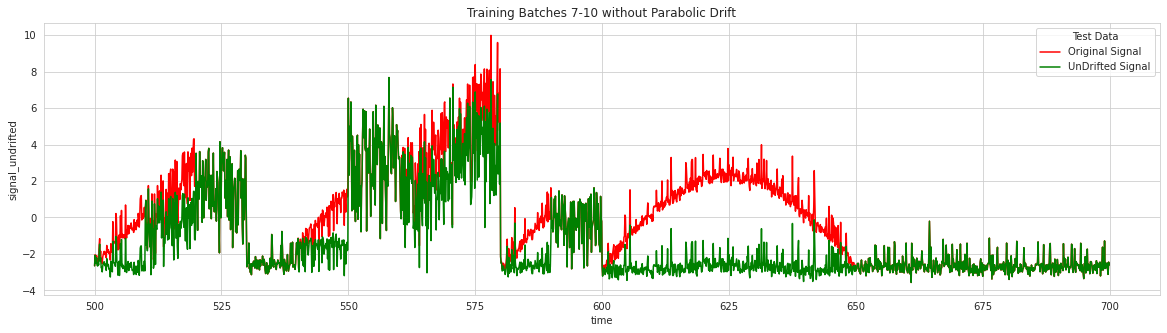

In [14]:
plt.figure(figsize=(20,5))
sns.lineplot(test.time[::1000],test.signal[::1000],color='r').set_title('Training Batches 7-10 with Parabolic Drift')
#plt.figure(figsize=(20,5))
g = sns.lineplot(test.time[::1000],test.signal_undrifted[::1000],color='g').set_title('Training Batches 7-10 without Parabolic Drift')
plt.legend(title='Test Data',loc='upper right', labels=['Original Signal', 'UnDrifted Signal'])
plt.show(g)

In [0]:
# 第二のカーネル
# https://www.kaggle.com/robikscube/ion-switching-5kfold-lgbm-tracking
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import lightgbm as lgb
#from tqdm.notebook import tqdm
from tqdm import tqdm
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error, f1_score
from datetime import datetime
import os

In [0]:
MODEL = "sub"

In [0]:
TARGET = 'open_channels'

TOTAL_FOLDS = 5
RANDOM_SEED = 529
MODEL_TYPE = 'LGBM'
LEARNING_RATE = 0.009
SHUFFLE = True
NUM_BOOST_ROUND = 500_000
EARLY_STOPPING_ROUNDS = 50
N_THREADS = -1
OBJECTIVE = 'regression'
METRIC = 'rmse'
NUM_LEAVES = 2**8+1
MAX_DEPTH = -1
FEATURE_FRACTION = 1
BAGGING_FRACTION = 1
BAGGING_FREQ = 0

In [0]:
ss = pd.read_csv('sample_submission.csv')
train['train'] = True
test['train'] = False
tt = pd.concat([train, test], sort=False).reset_index(drop=True)
tt['train'] = tt['train'].astype('bool')

In [0]:
###########
# TRACKING
###########

run_id = "{:%m%d_%H%M}".format(datetime.now())


def update_tracking(
        run_id, field, value, csv_file="./tracking.csv",
        integer=False, digits=None, nround=6,
        drop_broken_runs=False):
    """
    Tracking function for keep track of model parameters and
    CV scores. `integer` forces the value to be an int.
    """
    try:
        df = pd.read_csv(csv_file, index_col=[0])
    except:
        df = pd.DataFrame()
    if drop_broken_runs:
        df = df.dropna(subset=['1_f1'])
    if integer:
        value = round(value)
    elif digits is not None:
        value = round(value, digits)
    df.loc[run_id, field] = value  # Model number is index
    df = df.round(nround)
    df.to_csv(csv_file)

In [20]:
run_id

'0317_1500'

In [21]:
# Update Tracking
update_tracking(run_id, 'model_number', MODEL)
update_tracking(run_id, 'model_type', MODEL_TYPE)
update_tracking(run_id, 'seed', RANDOM_SEED, integer=True)
update_tracking(run_id, 'nfolds', TOTAL_FOLDS, integer=True)
update_tracking(run_id, 'lr', LEARNING_RATE)
update_tracking(run_id, 'shuffle', SHUFFLE)
update_tracking(run_id, 'boost_rounds', NUM_BOOST_ROUND)
update_tracking(run_id, 'es_rounds', EARLY_STOPPING_ROUNDS)
update_tracking(run_id, 'threads', N_THREADS)
update_tracking(run_id, 'objective', OBJECTIVE)
update_tracking(run_id, 'metric', METRIC)
update_tracking(run_id, 'num_leaves', NUM_LEAVES)
update_tracking(run_id, 'max_depth', MAX_DEPTH)
update_tracking(run_id, 'feature_fraction', FEATURE_FRACTION)
update_tracking(run_id, 'bagging_fraction', BAGGING_FRACTION)
update_tracking(run_id, 'bagging_freq', BAGGING_FREQ)

###########
# FEATURES
###########

# # Include batch
tt = tt.sort_values(by=['time']).reset_index(drop=True)
tt.index = ((tt.time * 10_000) - 1).values
tt['batch'] = tt.index // 50_000
tt['batch_index'] = tt.index - (tt.batch * 50_000)
tt['batch_slices'] = tt['batch_index'] // 5_000
tt['batch_slices2'] = tt.apply(lambda r: '_'.join(
    [str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)

# 50_000 Batch Features
tt['signal_batch_min'] = tt.groupby('batch')['signal_undrifted'].transform('min')
tt['signal_batch_max'] = tt.groupby('batch')['signal_undrifted'].transform('max')
tt['signal_batch_std'] = tt.groupby('batch')['signal_undrifted'].transform('std')
tt['signal_batch_mean'] = tt.groupby('batch')['signal_undrifted'].transform('mean')
tt['mean_abs_chg_batch'] = tt.groupby(['batch'])['signal_undrifted'].transform(
    lambda x: np.mean(np.abs(np.diff(x))))
tt['abs_max_batch'] = tt.groupby(
    ['batch'])['signal_undrifted'].transform(lambda x: np.max(np.abs(x)))
tt['abs_min_batch'] = tt.groupby(
    ['batch'])['signal_undrifted'].transform(lambda x: np.min(np.abs(x)))

tt['range_batch'] = tt['signal_batch_max'] - tt['signal_batch_min']
tt['maxtomin_batch'] = tt['signal_batch_max'] / tt['signal_batch_min']
tt['abs_avg_batch'] = (tt['abs_min_batch'] + tt['abs_max_batch']) / 2

# 5_000 Batch Features
tt['signal_batch_5k_min'] = tt.groupby(
    'batch_slices2')['signal_undrifted'].transform('min')
tt['signal_batch_5k_max'] = tt.groupby(
    'batch_slices2')['signal_undrifted'].transform('max')
tt['signal_batch_5k_std'] = tt.groupby(
    'batch_slices2')['signal_undrifted'].transform('std')
tt['signal_batch_5k_mean'] = tt.groupby(
    'batch_slices2')['signal_undrifted'].transform('mean')
tt['mean_abs_chg_batch_5k'] = tt.groupby(['batch_slices2'])[
    'signal_undrifted'].transform(lambda x: np.mean(np.abs(np.diff(x))))
tt['abs_max_batch_5k'] = tt.groupby(['batch_slices2'])[
    'signal_undrifted'].transform(lambda x: np.max(np.abs(x)))
tt['abs_min_batch_5k'] = tt.groupby(['batch_slices2'])[
    'signal_undrifted'].transform(lambda x: np.min(np.abs(x)))

tt['range_batch_5k'] = tt['signal_batch_5k_max'] - tt['signal_batch_5k_min']
tt['maxtomin_batch_5k'] = tt['signal_batch_5k_max'] / tt['signal_batch_5k_min']
tt['abs_avg_batch_5k'] = (tt['abs_min_batch_5k'] + tt['abs_max_batch_5k']) / 2


# add shifts
tt['signal_shift+1'] = tt.groupby(['batch']).shift(1)['signal_undrifted']
tt['signal_shift-1'] = tt.groupby(['batch']).shift(-1)['signal_undrifted']
tt['signal_shift+2'] = tt.groupby(['batch']).shift(2)['signal_undrifted']
tt['signal_shift-2'] = tt.groupby(['batch']).shift(-2)['signal_undrifted']

for c in ['signal_batch_min', 'signal_batch_max',
          'signal_batch_std', 'signal_batch_mean',
          'mean_abs_chg_batch', 'abs_max_batch',
          'abs_min_batch',
          'range_batch', 'maxtomin_batch', 'abs_avg_batch',
          'signal_shift+1', 'signal_shift-1',
          'signal_batch_5k_min', 'signal_batch_5k_max',
          'signal_batch_5k_std',
          'signal_batch_5k_mean', 'mean_abs_chg_batch_5k',
          'abs_max_batch_5k', 'abs_min_batch_5k',
          'range_batch_5k', 'maxtomin_batch_5k',
          'abs_avg_batch_5k','signal_shift+2','signal_shift-2']:
    tt[f'{c}_msignal'] = tt[c] - tt['signal']


# FEATURES = [f for f in tt.columns if f not in ['open_channels','index','time','train','batch',
#                                                'batch_index','batch_slices','batch_slices2']]


FEATURES = ['signal_undrifted',
            'signal_batch_min',
            'signal_batch_max',
            'signal_batch_std',
            'signal_batch_mean',
            'mean_abs_chg_batch',
            #'abs_max_batch',
            #'abs_min_batch',
            #'abs_avg_batch',
            'range_batch',
            'maxtomin_batch',
            'signal_batch_5k_min',
            'signal_batch_5k_max',
            'signal_batch_5k_std',
            'signal_batch_5k_mean',
            'mean_abs_chg_batch_5k',
            'abs_max_batch_5k',
            'abs_min_batch_5k',
            'range_batch_5k',
            'maxtomin_batch_5k',
            'abs_avg_batch_5k',
            'signal_shift+1',
            'signal_shift-1',
            # 'signal_batch_min_msignal',
            'signal_batch_max_msignal',
            'signal_batch_std_msignal',
            # 'signal_batch_mean_msignal',
            'mean_abs_chg_batch_msignal',
            'abs_max_batch_msignal',
            'abs_min_batch_msignal',
            'range_batch_msignal',
            'maxtomin_batch_msignal',
            'abs_avg_batch_msignal',
            'signal_shift+1_msignal',
            'signal_shift-1_msignal',
            'signal_batch_5k_min_msignal',
            'signal_batch_5k_max_msignal',
            'signal_batch_5k_std_msignal',
            'signal_batch_5k_mean_msignal',
            'mean_abs_chg_batch_5k_msignal',
            'abs_max_batch_5k_msignal',
            'abs_min_batch_5k_msignal',
            #'range_batch_5k_msignal',
            'maxtomin_batch_5k_msignal',
            'abs_avg_batch_5k_msignal',
            'signal_shift+2',
            'signal_shift-2']

print('....: FEATURE LIST :....')
print([f for f in FEATURES])

update_tracking(run_id, 'n_features', len(FEATURES), integer=True)
update_tracking(run_id, 'target', TARGET)

###########
# Metric
###########


def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    print(preds.shape)
    print(preds)
    preds = np.argmax(preds, axis=0)
#     score = metrics.cohen_kappa_score(labels, preds, weights = 'quadratic')
    score = f1_score(labels, preds, average='macro')
    return ('KaggleMetric', score, True)

....: FEATURE LIST :....
['signal_undrifted', 'signal_batch_min', 'signal_batch_max', 'signal_batch_std', 'signal_batch_mean', 'mean_abs_chg_batch', 'range_batch', 'maxtomin_batch', 'signal_batch_5k_min', 'signal_batch_5k_max', 'signal_batch_5k_std', 'signal_batch_5k_mean', 'mean_abs_chg_batch_5k', 'abs_max_batch_5k', 'abs_min_batch_5k', 'range_batch_5k', 'maxtomin_batch_5k', 'abs_avg_batch_5k', 'signal_shift+1', 'signal_shift-1', 'signal_batch_max_msignal', 'signal_batch_std_msignal', 'mean_abs_chg_batch_msignal', 'abs_max_batch_msignal', 'abs_min_batch_msignal', 'range_batch_msignal', 'maxtomin_batch_msignal', 'abs_avg_batch_msignal', 'signal_shift+1_msignal', 'signal_shift-1_msignal', 'signal_batch_5k_min_msignal', 'signal_batch_5k_max_msignal', 'signal_batch_5k_std_msignal', 'signal_batch_5k_mean_msignal', 'mean_abs_chg_batch_5k_msignal', 'abs_max_batch_5k_msignal', 'abs_min_batch_5k_msignal', 'maxtomin_batch_5k_msignal', 'abs_avg_batch_5k_msignal', 'signal_shift+2', 'signal_shift-

In [1]:
###########
# MODEL
###########
tt['train'] = tt['train'].astype('bool')
train = tt.query('train').copy()
test = tt.query('not train').copy()
train['open_channels'] = train['open_channels'].astype(int)
X = train[FEATURES]
X_test = test[FEATURES]
y = train[TARGET].values
sub = test[['time']].copy()
groups = train['batch']

if OBJECTIVE == 'multiclass':
    NUM_CLASS = 11
else:
    NUM_CLASS = 1

# define hyperparammeter (some random hyperparammeters)
params = {'learning_rate': LEARNING_RATE,
          'max_depth': MAX_DEPTH,
          'num_leaves': NUM_LEAVES,
          'feature_fraction': FEATURE_FRACTION,
          'bagging_fraction': BAGGING_FRACTION,
          'bagging_freq': BAGGING_FREQ,
          'n_jobs': N_THREADS,
          'seed': RANDOM_SEED,
          'metric': METRIC,
          'objective': OBJECTIVE,
          'num_class': NUM_CLASS
          }

kfold = KFold(n_splits=TOTAL_FOLDS, shuffle=SHUFFLE, random_state=RANDOM_SEED)

oof_df = train[['signal_undrifted', 'open_channels']].copy()
fi_df = pd.DataFrame(index=FEATURES)

fold = 1  # init fold counter
for tr_idx, val_idx in kfold.split(X, y, groups=groups):
    print(f'====== Fold {fold:0.0f} of {TOTAL_FOLDS} ======')
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    train_set = lgb.Dataset(X_tr, y_tr)
    val_set = lgb.Dataset(X_val, y_val)

    model = lgb.train(params,
                      train_set,
                      num_boost_round=NUM_BOOST_ROUND,
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                      valid_sets=[train_set, val_set],
                      verbose_eval=50)
    # feval=lgb_Metric)

    if OBJECTIVE == 'multi_class':
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        preds = np.argmax(preds, axis=1)
        test_preds = model.predict(X_test, num_iteration=model.best_iteration)
        test_preds = np.argmax(test_preds, axis=1)
    elif OBJECTIVE == 'regression':
        preds = model.predict(X_val, num_iteration=model.best_iteration)
        preds = np.round(np.clip(preds, 0, 10)).astype(int)
        test_preds = model.predict(X_test, num_iteration=model.best_iteration)
        test_preds = np.round(np.clip(test_preds, 0, 10)).astype(int)

    oof_df.loc[oof_df.iloc[val_idx].index, 'oof'] = preds
    sub[f'open_channels_fold{fold}'] = test_preds

    f1 = f1_score(oof_df.loc[oof_df.iloc[val_idx].index]['open_channels'],
                  oof_df.loc[oof_df.iloc[val_idx].index]['oof'],
                  average='macro')
    rmse = np.sqrt(mean_squared_error(oof_df.loc[oof_df.index.isin(val_idx)]['open_channels'],
                                      oof_df.loc[oof_df.index.isin(val_idx)]['oof']))

    update_tracking(run_id, f'{fold}_best_iter', model.best_iteration, integer=True)
    update_tracking(run_id, f'{fold}_rmse', rmse)
    update_tracking(run_id, f'{fold}_f1', f1)
    fi_df[f'importance_{fold}'] = model.feature_importance()
    print(f'Fold {fold} - validation f1: {f1:0.5f}')
    print(f'Fold {fold} - validation rmse: {rmse:0.5f}')

    fold += 1

oof_f1 = f1_score(oof_df['open_channels'],
                  oof_df['oof'],
                  average='macro')
oof_rmse = np.sqrt(mean_squared_error(oof_df['open_channels'],
                                      oof_df['oof']))

update_tracking(run_id, f'oof_f1', oof_f1)
update_tracking(run_id, f'oof_rmse', oof_rmse)

###############
# SAVE RESULTS
###############

s_cols = [s for s in sub.columns if 'open_channels' in s]

sub['open_channels'] = sub[s_cols].median(axis=1).astype(int)
sub.to_csv(f'./pred_2020_0317.csv', index=False)
sub[['time', 'open_channels']].to_csv(f'./sub_2020_0317.csv',
                                      index=False,
                                      float_format='%0.4f')

upload_file_2 = drive.CreateFile()
upload_file_2.SetContentFile("pred_2020_0317.csv")
upload_file_2.Upload()
# submitする時
!kaggle competitions submit -c titanic -f pred_2020_0317.csv -m "second submit"

oof_df.to_csv(f'./oof__2020_0317.csv', index=False)

fi_df['importance'] = fi_df.sum(axis=1)
fi_df.to_csv(f'./fi__2020_0317.csv', index=True)



fig, ax = plt.subplots(figsize=(15, 30))
fi_df.sort_values('importance')['importance'] \
    .plot(kind='barh',
          figsize=(15, 30),
          title=f'{MODEL} - Feature Importance',
          ax=ax)
plt.savefig(f'./{MODEL}__{oof_f1:0.6}.png')


NameError: ignored

In [0]:
upload_file_2 = drive.CreateFile()
upload_file_2.SetContentFile("sample_submission.csv")
upload_file_2.Upload()

In [29]:
!ls

adc.json     sample_data		test.csv      train.csv
drive	     sample_submission.csv	test.csv.zip  train.csv.zip
kaggle.json  sample_submission.csv.zip	tracking.csv


In [2]:
train

NameError: ignored